Initialize normal optimization problem

Number of nodes: 11
Number of edges: 16
Edges: EdgeList[(0, 1), (0, 2), (0, 4), (0, 7), (1, 4), (1, 9), (2, 3), (2, 4), (2, 6), (3, 5), (3, 6), (5, 6), (7, 8), (7, 9), (8, 10), (9, 10)]


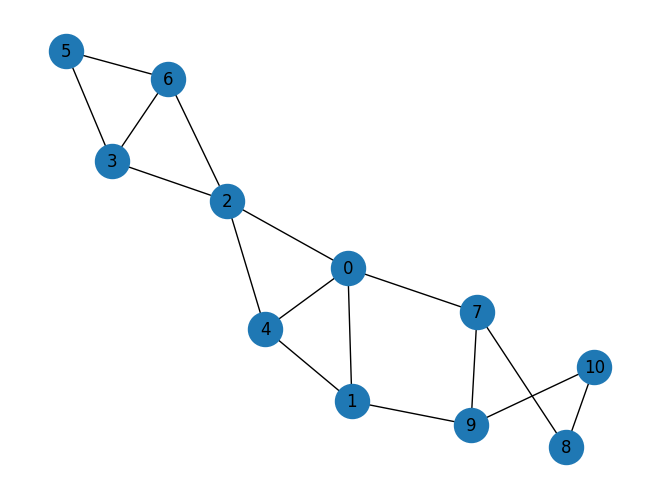

In [1]:
import random
import rustworkx as rx
from rustworkx import is_connected
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np


def make_default_graph(nodes = 4):
    graph = rx.PyGraph()
    graph.add_nodes_from(np.arange(0,nodes,1))
    edge_list = [(0, 1, 1.0), (0, 2, 2.0), (0, 3, 0.5), (1, 2, 1.0), (2, 3, 1.0)]
    """default:
    graph.add_nodes_from(np.arange(0,nodes,1))
    edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]"""
    graph.add_edges_from(edge_list)
    return graph

def make_random_graph(nodes = 5):
    default_weight = 1
    graph = rx.PyGraph()
    rng = np.random.default_rng(seed = 173)
    graph.add_nodes_from(np.arange(0,nodes,1))
    edge_list= [(random.randint(0,nodes-1),random.randint(0,nodes-1),1) for _ in range(2*nodes)]
    
    edge_list = [edge for edge in edge_list if (edge[1],edge[0],1.0) not in edge_list] #remove dupes
#TODO: lage det til et set

    graph.add_edges_from(edge_list)

    while not is_connected(graph):
        #naive function iteratively adds edges until the graph is connected. can be immensely improved but runs fast enough
        edge = (random.randint(0,nodes-1),random.randint(0,nodes-1),1)
        mirror_edge = (edge[1],edge[0],1.0)

        if edge not in graph.edge_list() and mirror_edge not in graph.edge_list(): #adding, but avoiding dupes
            graph.add_edges_from([(random.randint(0,nodes-1),random.randint(0,nodes-1),1) for _ in range(1)])

    return graph
from load_data import load_graph_from_csv
num_qubits =11 
depth = 3
graph = make_random_graph(num_qubits)

graph = load_graph_from_csv('data/11_nodes_links_scand.csv')
print("Number of nodes:", graph.num_nodes())
print("Number of edges:", graph.num_edges())
print("Edges:", graph.edge_list())

draw_graph(graph, node_size = 600, with_labels = True)

Create a cost function through a hamiltonian from the graph

In [2]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph):
    """ 
    Convert graph to pauli list.
    Pauli lists are operation instructions for the quantum circuit, and are 
    strings with mostly I-s and some Z-s. 
    They represent Z-operations on some qubits and I-operations on others.
    """

    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"]*len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0],edge[1])
        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)

print("Cost function hamiltonian:", cost_hamiltonian)

Cost function hamiltonian: SparsePauliOp(['IIIIIIIIIZZ', 'IIIIIIIIZIZ', 'IIIIIIZIIIZ', 'IIIZIIIIIIZ', 'IIIIIIZIIZI', 'IZIIIIIIIZI', 'IIIIIIIZZII', 'IIIIIIZIZII', 'IIIIZIIIZII', 'IIIIIZIZIII', 'IIIIZIIZIII', 'IIIIZZIIIII', 'IIZZIIIIIII', 'IZIZIIIIIII', 'ZIZIIIIIIII', 'ZZIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


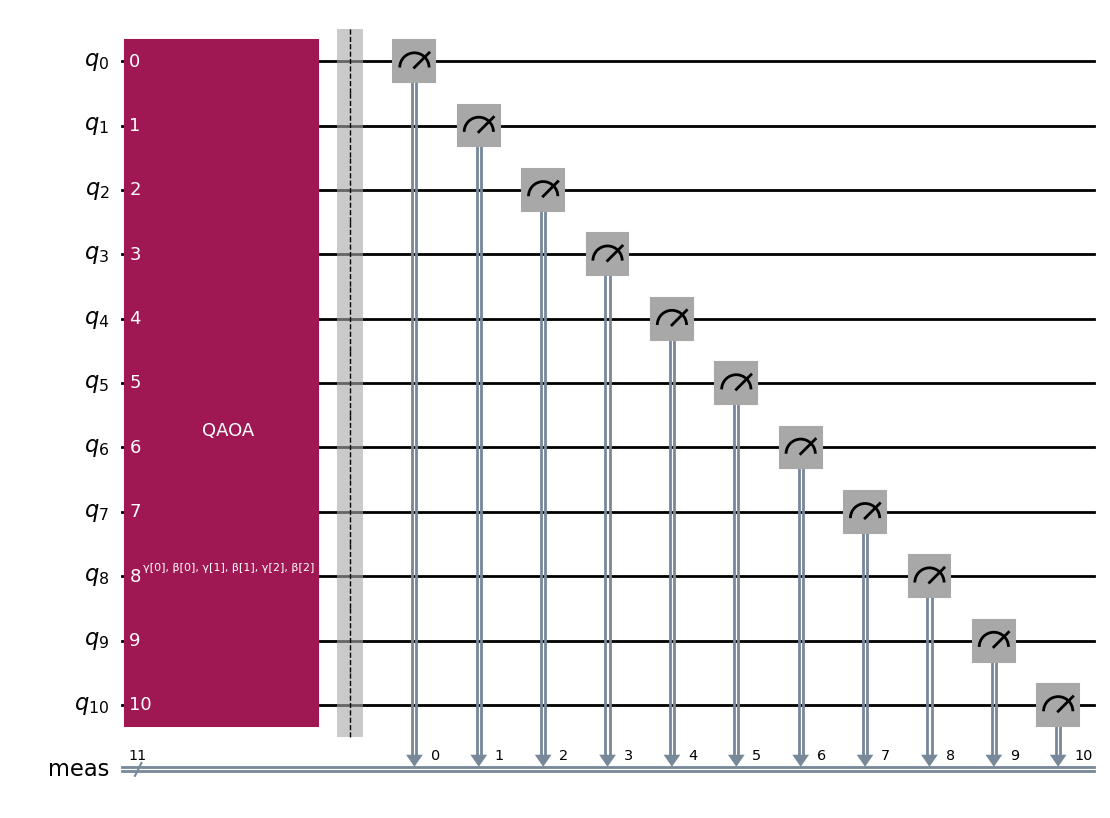

In [3]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator = cost_hamiltonian, reps = depth)
circuit.measure_all()

circuit.draw('mpl')


In [4]:
circuit.parameters



ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2])])

Optimize the circuit 

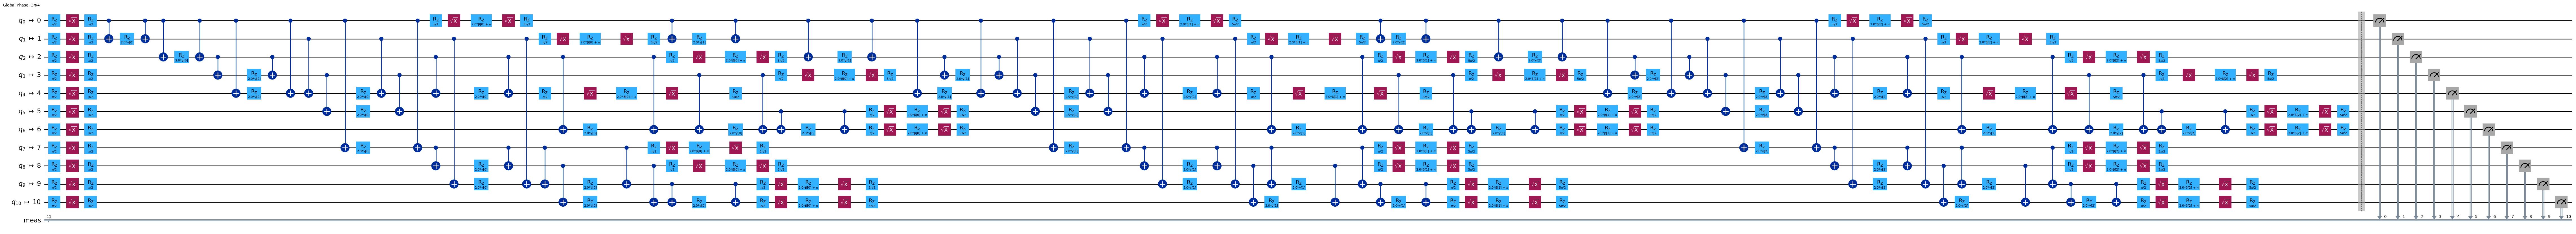

In [5]:
from qiskit_ibm_runtime import fake_provider
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = GenericBackendV2(num_qubits=num_qubits)

pm = generate_preset_pass_manager(optimization_level=0,backend=backend)

candidate_circuit = pm.run(circuit)

candidate_circuit.draw('mpl', fold=False, idle_wires=False)



Execute using qiskit orimitives - what is a qiskit primitive?

In [6]:
initial_gamma = np.pi
initial_beta = np.pi/2 #todo change 
init_params = [(initial_gamma, initial_beta) for _ in range(depth)]

init_params = [number for tup in init_params for number in tup]


In [7]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    #TODO: see if this can be optimized
    #transform observable defined on virtual qubits to an observable defined on all physical qubits

    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

print(cost_hamiltonian.apply_layout(candidate_circuit.layout))
print(candidate_circuit.layout)

with Session(backend=backend) as session:

    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    #error supression - is this necessary? my backend is noiseless - ? 
    #if needed, write in later
    """
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"  

    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations="auto"
"""
    result = minimize(
        cost_func_estimator, 
        init_params,
        args= (candidate_circuit, cost_hamiltonian, estimator),
        method = "COBYLA",
        tol = 1e-2
    )
    print(result)



SparsePauliOp(['IIIIIIIIIZZ', 'IIIIIIIIZIZ', 'IIIIIIZIIIZ', 'IIIZIIIIIIZ', 'IIIIIIZIIZI', 'IZIIIIIIIZI', 'IIIIIIIZZII', 'IIIIIIZIZII', 'IIIIZIIIZII', 'IIIIIZIZIII', 'IIIIZIIZIII', 'IIIIZZIIIII', 'IIZZIIIIIII', 'IZIZIIIIIII', 'ZIZIIIIIIII', 'ZZIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
TranspileLayout(initial_layout=Layout({
0: Qubit(QuantumRegister(11, 'q'), 0),
1: Qubit(QuantumRegister(11, 'q'), 1),
2: Qubit(QuantumRegister(11, 'q'), 2),
3: Qubit(QuantumRegister(11, 'q'), 3),
4: Qubit(QuantumRegister(11, 'q'), 4),
5: Qubit(QuantumRegister(11, 'q'), 5),
6: Qubit(QuantumRegister(11, 'q'), 6),
7: Qubit(QuantumRegister(11, 'q'), 7),
8: Qubit(QuantumRegister(11, 'q'), 8),
9: Qubit(QuantumRegister(11, 'q'), 9),
10: Qubit(QuantumRegister(11, 'q'), 10)
}), input_qubit_mapping={Qubit(QuantumRegister(11, 'q'), 0): 0, Qubit(QuantumRegister(11, 'q'), 1): 1, Qubit(QuantumRegist

c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimul

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.273726273726274
       x: [ 3.867e+00  2.083e+00  3.318e+00  3.162e-01  3.057e+00
            2.235e+00]
    nfev: 49
   maxcv: 0.0


In [8]:
with Session(backend=backend) as session:

    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000
    params =  [3.417e+00 , 1.692e+00 , 3.968e+00 , 1.957e+00,  4.027e+00,
            1.790e+00]

    cost = cost_func_estimator(params, candidate_circuit, cost_hamiltonian, estimator)
    print(cost)

-0.3336663336663338


c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


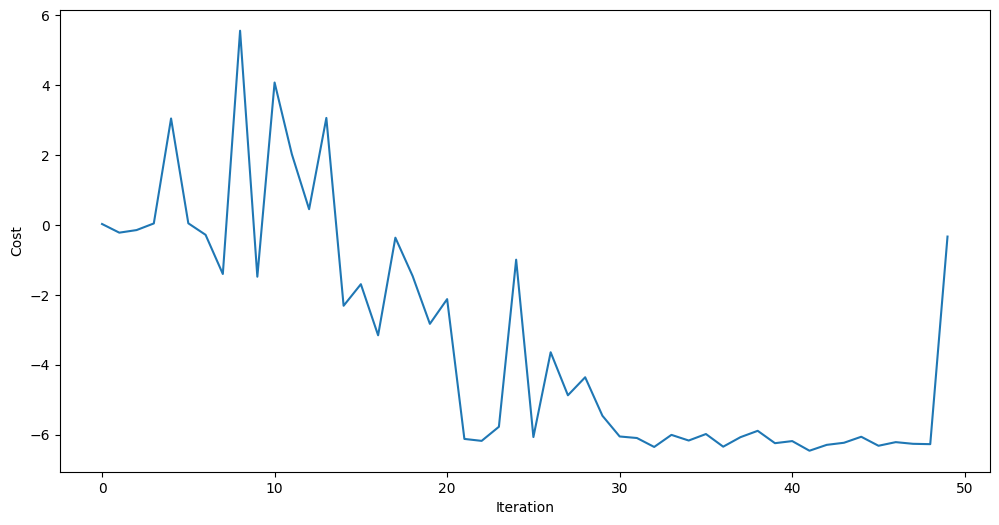

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

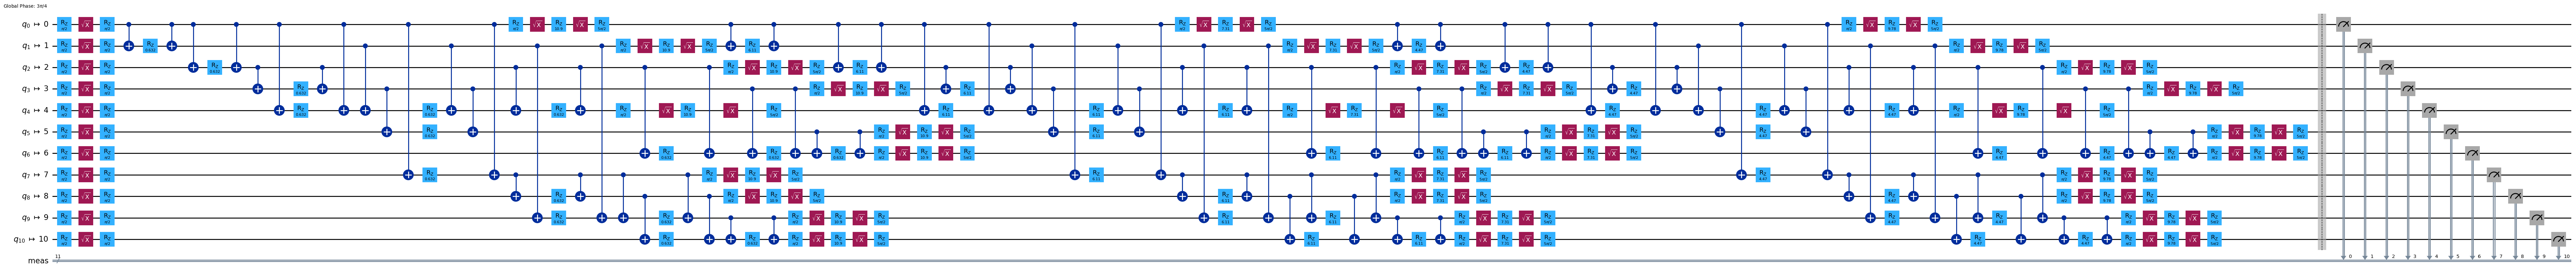

In [10]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold= False, idle_wires=False)

In [11]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
sampler.options.default_shots=10000

pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
print(counts_int)
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{881: 159, 764: 4, 1265: 67, 1094: 28, 1207: 25, 806: 124, 1573: 83, 785: 7, 1062: 50, 1204: 100, 852: 69, 1212: 14, 1242: 255, 980: 8, 857: 312, 825: 160, 1210: 96, 1082: 11, 782: 67, 1266: 91, 171: 4, 984: 25, 1625: 130, 820: 145, 325: 4, 1067: 16, 1206: 50, 1123: 15, 337: 11, 230: 9, 215: 2, 1368: 4, 474: 118, 916: 3, 398: 63, 1337: 23, 1561: 15, 1063: 23, 838: 68, 808: 13, 1227: 181, 1190: 278, 843: 93, 1295: 20, 1178: 17, 1908: 2, 473: 9, 1593: 62, 688: 9, 527: 1, 1324: 2, 1180: 39, 864: 14, 721: 4, 664: 7, 1186: 44, 1572: 11, 486: 13, 779: 6, 331: 43, 780: 6, 1241: 132, 867: 45, 1255: 6, 861: 49, 1262: 6, 1222: 147, 692: 88, 1549: 34, 1702: 47, 313: 16, 1829: 32, 1008: 15, 1189: 48, 805: 273, 1245: 21, 783: 11, 880: 24, 218: 36, 1649: 68, 585: 13, 856: 81, 1805: 14, 1734: 22, 1778: 2, 1314: 5, 1817: 8, 985: 35, 1243: 16, 418: 21, 1833: 2, 1766: 6, 1606: 2, 1034: 1, 1355: 74, 668: 32, 1233: 24, 1605: 36, 340: 2, 1236: 42, 1209: 92, 1716: 31, 1623: 1, 669: 2, 1447: 4, 1166: 140, 12

c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


In [12]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())

most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0]


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_40684\2624617538.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


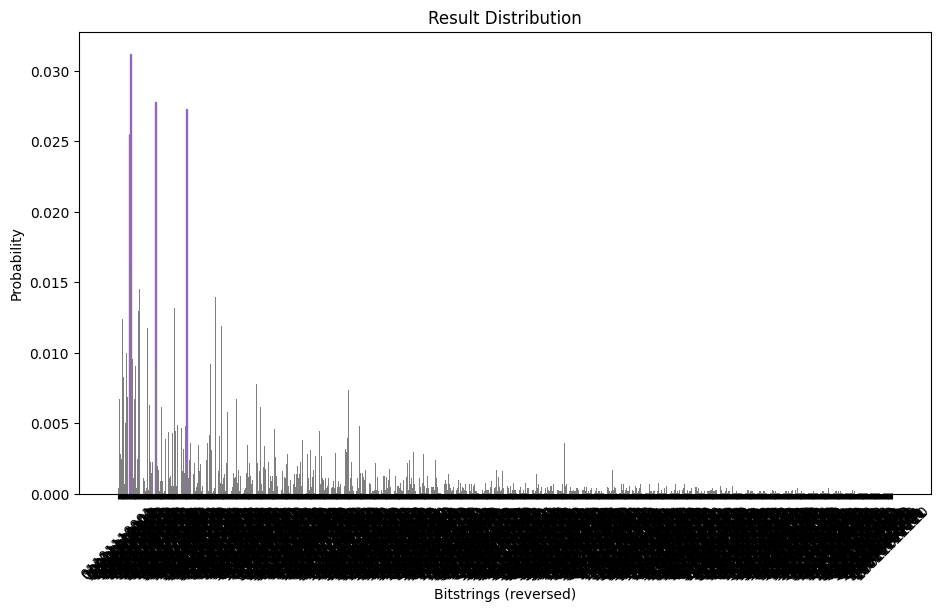

In [13]:
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

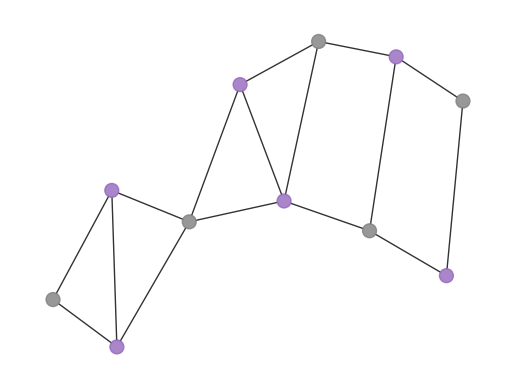

In [14]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [15]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in set(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 14


CPLEX implementation of the same problem

-2x_0*x_1-2x_0*x_2-2x_0*x_4-2x_0*x_7-2x_1*x_4-2x_1*x_9-2x_2*x_3-2x_2*x_4-2x_2*x_6-2x_3*x_5-2x_3*x_6-2x_5*x_6-2x_7*x_8-2x_7*x_9-2x_8*x_10-2x_9*x_10+4x_0+3x_1+4x_2+3x_3+3x_4+2x_5+3x_6+3x_7+2x_8+3x_9+2x_10
solution for: MaxCut
objective: 14
status: OPTIMAL_SOLUTION(2)
x_1 = 1
x_2 = 1
x_5 = 1
x_7 = 1
x_10 = 1
Result bitstring quantum: [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Result classical:  [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Same solution True


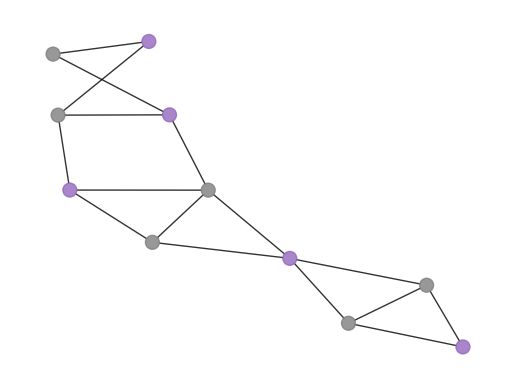

In [16]:
import cplex
from docplex.mp.model import Model
from rustworkx import NoEdgeBetweenNodes


mdl = Model(name="MaxCut")

variables = mdl.binary_var_list(len(graph), name='x')


objective = 0

for i,var in enumerate(variables): #hvorfor går jeg ikke bare gjennom edges??
    for j,var2 in enumerate(variables):
        if i != j and i> j:  
            try:
                graph.get_edge_data(i,j)
                objective += var + var2 - 2*var*var2
            except NoEdgeBetweenNodes:
                pass

print(objective)
mdl.maximize(objective)

solution = mdl.solve()


solution.display()

print("Result bitstring quantum:", most_likely_bitstring)

bitstring = [int(var.solution_value) for var in variables]
print("Result classical: ", bitstring)
    
bools = [a==b for a,b in zip(bitstring,most_likely_bitstring)]
bools_reversed =[a!=b for a,b in zip(bitstring,most_likely_bitstring)]
plot_result(graph, bitstring)
    
print("Same solution", all(bools) or all(bools_reversed)) #same cut but different partitions


## MA-QAOA


[[Parameter(γ_0_0), Parameter(γ_0_1), Parameter(γ_0_2), Parameter(γ_0_3), Parameter(γ_0_4), Parameter(γ_0_5), Parameter(γ_0_6), Parameter(γ_0_7), Parameter(γ_0_8), Parameter(γ_0_9), Parameter(γ_0_10), Parameter(γ_0_11), Parameter(γ_0_12), Parameter(γ_0_13), Parameter(γ_0_14), Parameter(γ_0_15)], [Parameter(γ_1_0), Parameter(γ_1_1), Parameter(γ_1_2), Parameter(γ_1_3), Parameter(γ_1_4), Parameter(γ_1_5), Parameter(γ_1_6), Parameter(γ_1_7), Parameter(γ_1_8), Parameter(γ_1_9), Parameter(γ_1_10), Parameter(γ_1_11), Parameter(γ_1_12), Parameter(γ_1_13), Parameter(γ_1_14), Parameter(γ_1_15)], [Parameter(γ_2_0), Parameter(γ_2_1), Parameter(γ_2_2), Parameter(γ_2_3), Parameter(γ_2_4), Parameter(γ_2_5), Parameter(γ_2_6), Parameter(γ_2_7), Parameter(γ_2_8), Parameter(γ_2_9), Parameter(γ_2_10), Parameter(γ_2_11), Parameter(γ_2_12), Parameter(γ_2_13), Parameter(γ_2_14), Parameter(γ_2_15)]]


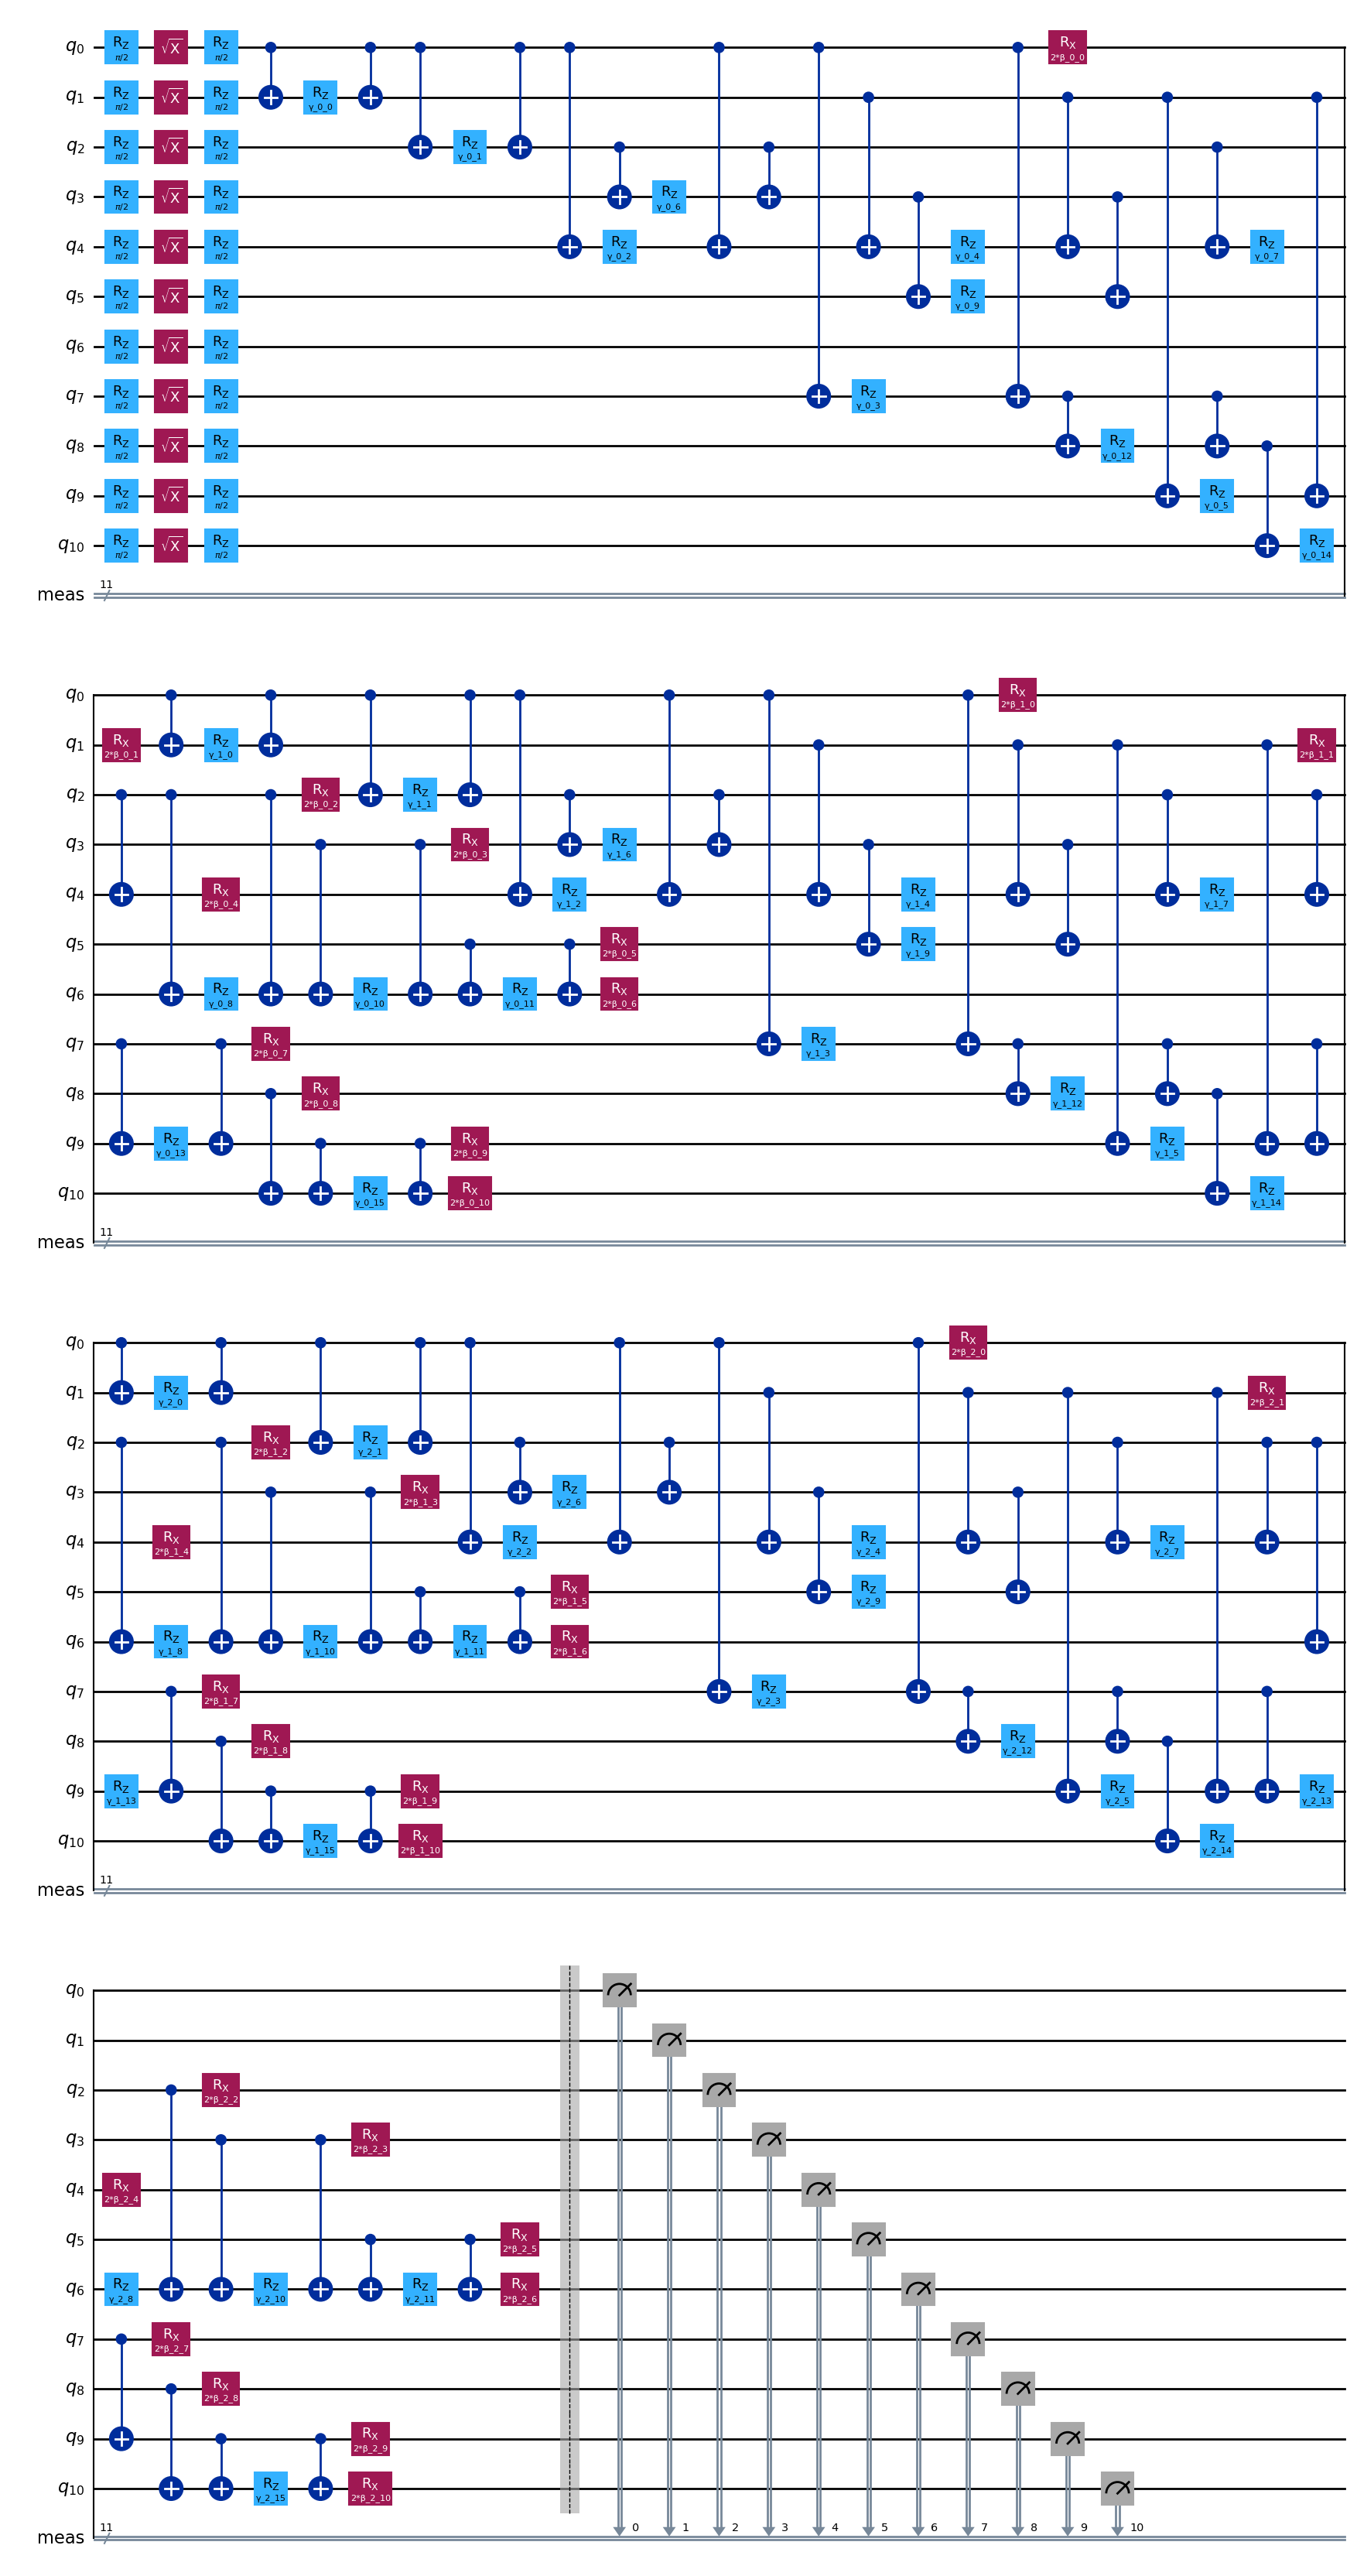

In [17]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import HGate
from qiskit.circuit import Parameter
qc = QuantumCircuit(num_qubits)
qc.qubits


def build_circuit(qc, depth = 2, multiangle = False):
    """ Build a circuit."""

    #if not multiangle:

    initial_gamma = np.pi
    initial_beta = np.pi/2 #todo change 
    init_params = [(initial_gamma, initial_beta) for _ in range(depth)]
    init_params = [number for tup in init_params for number in tup]

    multiangle_gammas = [[Parameter(f'γ_{l}_{i}') for i in range(len(graph.edges()))] for l in range(depth)]
    multiangle_betas = [[Parameter(f'β_{l}_{i}') for i in range(num_qubits)] for l in range(depth)]
    print(multiangle_gammas)

    for _ in range(num_qubits): #sjekk len,
        
        qc.rz(np.pi/2, _)
        qc.sx(_)
        qc.rz(np.pi/2, _)
    for i in range(depth):
        if multiangle:
            for idx, edge in enumerate(graph.edge_list()):
                qc.cx(edge[0], edge[1])
                qc.rz(multiangle_gammas[i][idx], edge[1])
                qc.cx(edge[0], edge[1])
            for idx in range(num_qubits):
                qc.rx(2*multiangle_betas[i][idx], idx)
        else:        
            for edge in graph.edge_list():
                print(edge)
                qc.cx(edge[0], edge[1])
                qc.rz(initial_beta, edge[1])
                qc.cx(edge[0], edge[1])
            for qubit in range(num_qubits):
                qc.rx(2*initial_beta, qubit)
    qc.measure_all()
build_circuit(qc, depth,True)

qc.draw('mpl')

In [18]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

param_length = (num_qubits + len(graph.edges()))*depth #(m + n)*p
init_params = np.random.uniform(0,np.pi,param_length)
print(init_params)

backend = GenericBackendV2(num_qubits=num_qubits)
pm = generate_preset_pass_manager(optimization_level=2,backend=backend)
candidate_circuit = pm.run(qc)

candidate_circuit.draw('mpl', fold=False, idle_wires=False)


objective_func_vals = []
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    #TODO: see if this can be optimized
    #transform observable defined on virtual qubits to an observable defined on all physical qubits

    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

print(cost_hamiltonian.apply_layout(candidate_circuit.layout))
print(candidate_circuit.layout)
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

with Session(backend=backend) as session:

    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    #error supression - is this necessary? my backend is noiseless - ? 
    #if needed, write in later
    """
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"  

    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations="auto"
"""
    result = minimize(
        cost_func_estimator, 
        init_params,
        args= (candidate_circuit, cost_hamiltonian, estimator),
        method = "COBYLA",
        tol = 1e-2
    )
    print(result)

[0.33977756 0.32320176 0.68365894 0.17241822 3.06204805 1.37608352
 2.28616317 0.79725486 0.41413214 1.85791007 0.80626935 1.7063814
 2.91027851 1.19904035 1.70459541 1.12004961 2.84606673 0.20013199
 1.86608499 0.67340419 0.66364158 0.07037398 2.30182684 2.65967354
 0.91764496 1.8930786  0.97756498 0.59108307 0.865735   1.07936378
 0.81676581 0.90692581 1.09332065 0.58246092 0.62454831 2.45200982
 0.32308145 2.00661913 1.02242217 1.03422045 2.07028478 0.00867043
 0.11212019 0.11280073 1.83822383 1.09782965 2.57334852 0.9648464
 2.49666398 1.17118047 0.15652906 0.9806511  1.70609671 2.79243174
 0.53065162 0.20091687 2.40463203 2.68995109 2.24035052 2.9568085
 0.90113031 2.70625819 1.17037343 2.55801354 1.48808213 1.12821063
 0.39239836 1.57855409 0.23761179 0.85491181 2.50089281 1.0873212
 0.38917821 2.95120085 0.95294726 0.88992904 2.96015043 2.70292504
 1.16512639 2.56476256 0.78364316]
SparsePauliOp(['IZIIZIIIIII', 'IZIZIIIIIII', 'ZZIIIIIIIII', 'IZIIIIIZIII', 'ZIIIZIIIIII', 'IIIIZII

c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimul

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.022977022977022
       x: [ 3.198e-01  8.692e-01 ...  2.564e+00  8.471e-01]
    nfev: 440
   maxcv: 0.0


c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


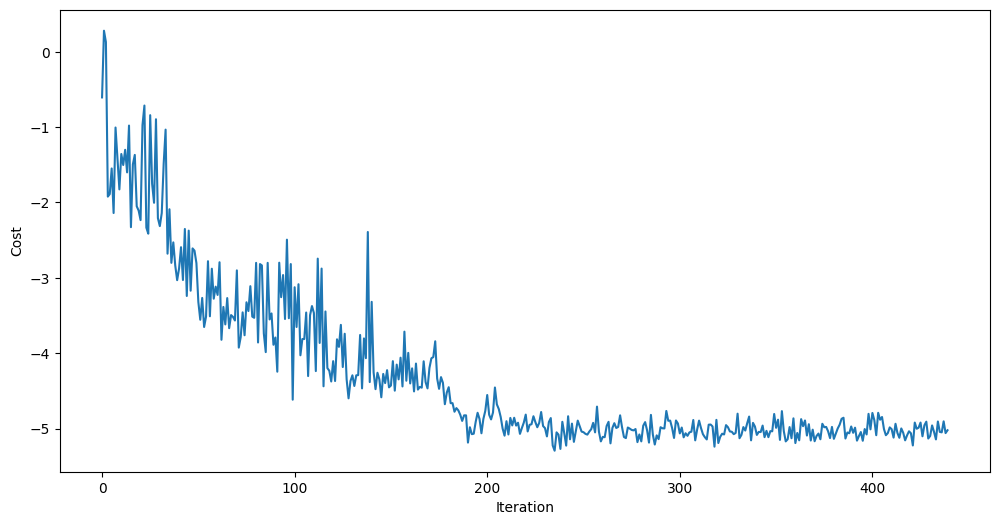

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

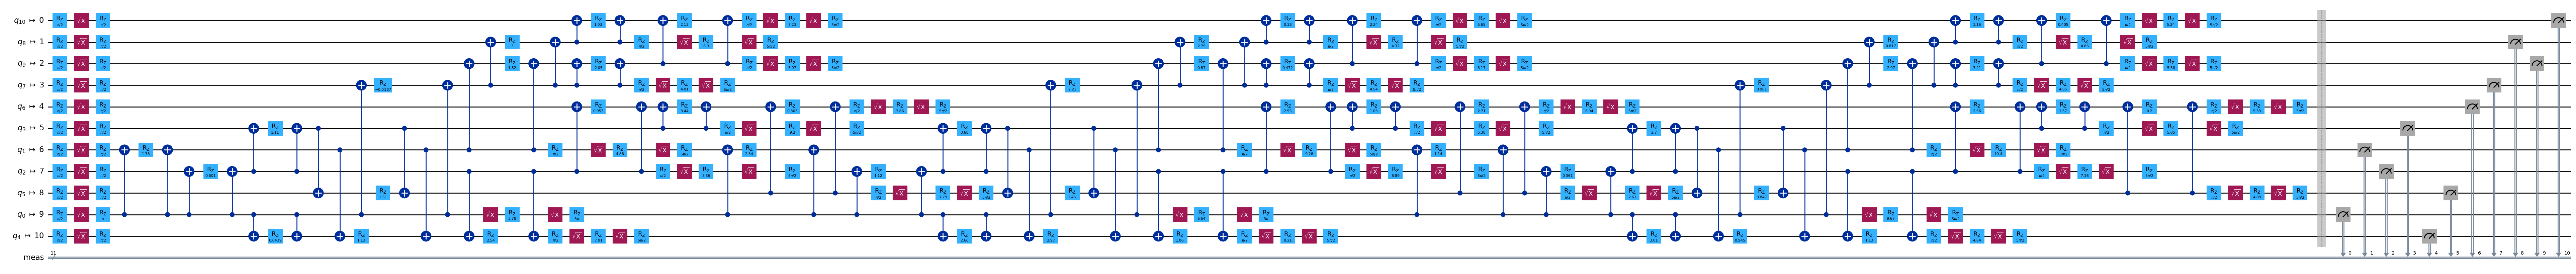

In [20]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold= False, idle_wires=False)

{372: 6, 1198: 107, 1977: 4, 697: 26, 884: 74, 1238: 167, 1377: 8, 1206: 71, 836: 38, 1121: 10, 1213: 36, 686: 34, 1064: 7, 1254: 77, 820: 36, 808: 20, 1325: 11, 1266: 57, 677: 15, 837: 286, 824: 138, 809: 165, 1205: 32, 1234: 108, 1208: 47, 471: 3, 795: 15, 1211: 30, 852: 106, 624: 1, 698: 10, 813: 106, 669: 13, 849: 87, 1193: 89, 601: 5, 1393: 36, 881: 115, 1466: 32, 1110: 11, 794: 14, 1022: 1, 1105: 1, 1187: 5, 1090: 8, 709: 20, 1401: 6, 1196: 30, 783: 22, 1210: 277, 1237: 48, 1220: 20, 883: 12, 557: 15, 339: 4, 1167: 45, 1270: 108, 582: 4, 1373: 2, 810: 48, 1255: 50, 848: 63, 1178: 95, 1188: 5, 1597: 1, 1294: 20, 777: 100, 1733: 10, 825: 120, 1521: 6, 736: 1, 998: 1, 629: 5, 780: 27, 1706: 4, 597: 11, 448: 1, 1222: 101, 971: 1, 1243: 15, 1524: 6, 706: 18, 1098: 8, 806: 3, 1013: 8, 583: 8, 773: 4, 1369: 16, 1700: 6, 1135: 3, 1166: 99, 1223: 151, 685: 10, 937: 9, 1547: 4, 807: 24, 1494: 21, 1171: 2, 1242: 96, 798: 34, 690: 4, 1195: 121, 1317: 6, 1236: 16, 1086: 2, 1181: 28, 905: 7, 1

c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


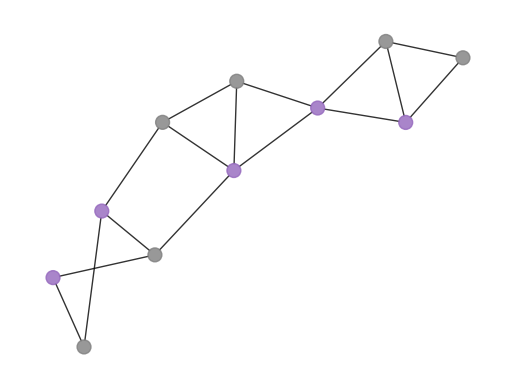

In [21]:
sampler = Sampler(mode=backend)
sampler.options.default_shots=10000

pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
print(job)
counts_int = job.result()[0].data.meas.get_int_counts()
print(counts_int)
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())

most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in set(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

plot_result(graph, most_likely_bitstring)